# Lights model tutorial

In [1]:
#%reset -f
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore', ConvergenceWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import KaplanMeierFitter
from tick.plot import plot_point_process
from lights.simulation import SimuJointLongitudinalSurvival
from lights.base.utils import heatmap, annotate_heatmap, gompertz_pdf, \
                              gompertz_survival, visualize_vect_learning, visualize_vect_per_group
from lights.base.base import feat_representation_extraction
from sklearn.model_selection import ShuffleSplit
from lifelines.utils import concordance_index as c_index_score
from IPython.display import Markdown, display
from scipy.stats import beta
from matplotlib import rc
from plotly import graph_objects as go
#rc('text', usetex=True)
%matplotlib inline

def printmd(string):
    display(Markdown(string))

## Generate data

In [2]:
simu = SimuJointLongitudinalSurvival(seed=123, n_long_features=5, n_samples=500, 
                                     n_time_indep_features=10)
                                    
X, Y, T, delta = simu.simulate()
print("\nLevel of censoring: %.2f%%" % (100*(1 - delta.mean())))

-----------------------------------------------------------
Launching simulation using SimuJointLongitudinalSurvival...
Done simulating using SimuJointLongitudinalSurvival in 1.50e-01 seconds.

Level of censoring: 39.20%


### Visualize parameter vectors
We generate survival times with a risk model of the form
$$\begin{align*}
\lambda_i(t|G_i = k) &= \lambda_0(t) \exp \Big\{ x_i^\top \xi + \sum_{l=1}^L \gamma_{k,1}^l (\beta_{k,1}^l + \beta_{k,2}^l t + b_{i,1}^l + b_{i,2}^l t) + (\gamma_{k,2,1}^l b_{i,1}^l + \gamma_{k,2,2}^l b_{i,2}^l) + \gamma_{k,3}^l (\beta_{k,2}^l + b_{i,2}^l) \Big\} \\
&= \lambda_0(t) \exp \big\{ \iota_{i,k,1} + \iota_{i,k,2} t \big\}
\end{align*}$$

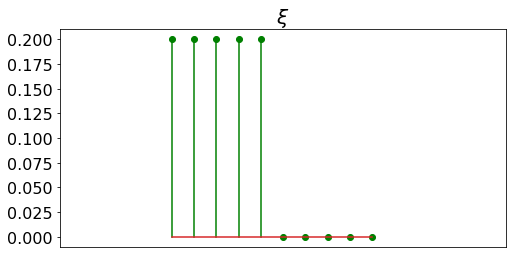

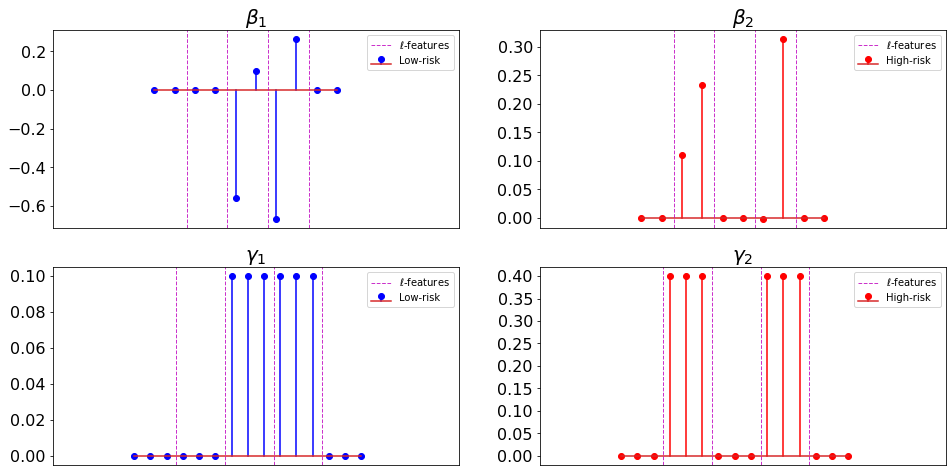

In [8]:
xi, betas, gammas = simu.time_indep_coeffs, simu.fixed_effect_coeffs, simu.asso_coeffs

fig = plt.figure(figsize=(8, 4))
fontsize = 16
ax = fig.add_subplot(111)
ax.stem(xi, linefmt='g-', markerfmt='go')
ax.set_xlim([-5, len(xi) + 5])
ax.set_title(r"$\xi$", fontsize=fontsize+4)
plt.yticks(fontsize=fontsize)
plt.tick_params(axis='x', bottom=False, labelbottom=False)
plt.show()

fig = plt.figure(figsize=(16, 8))
names, colors, labels = ['beta', 'gamma'], ['b', 'r'], ['Low-risk', 'High-risk']
j = 1

for i, vectors in enumerate([betas, gammas]):
    for k in [0, 1]:
        name = names[i]
        ax = fig.add_subplot(2,2,j)
        j += 1
        ax.stem(vectors[k], linefmt='%s-' % colors[k], 
                markerfmt='%so' % colors[k], label=labels[k])
        ax.set_xlim([-5, len(vectors[k]) + 5])
        ax.set_title(r"$\%s_%s$" % (name, k+1), fontsize=fontsize+4)
        plt.yticks(fontsize=fontsize)
        plt.tick_params(axis='x', bottom=False, labelbottom=False)
        plt.legend(fontsize=fontsize-2)
        visualize_vect_per_group(vectors[k], simu.n_long_features, ax)
plt.show()

### Visualize simulated times

We choose a Gompertz distribution for the baseline, that is
$$\lambda_0(t) = \kappa_1 \kappa_2 \exp(\kappa_2t)$$
with $\kappa_1 > 0$ and $\kappa_2 \in R$ the scale and shape parameters respectively.

kappa_1=0.05, kappa_2=0.1


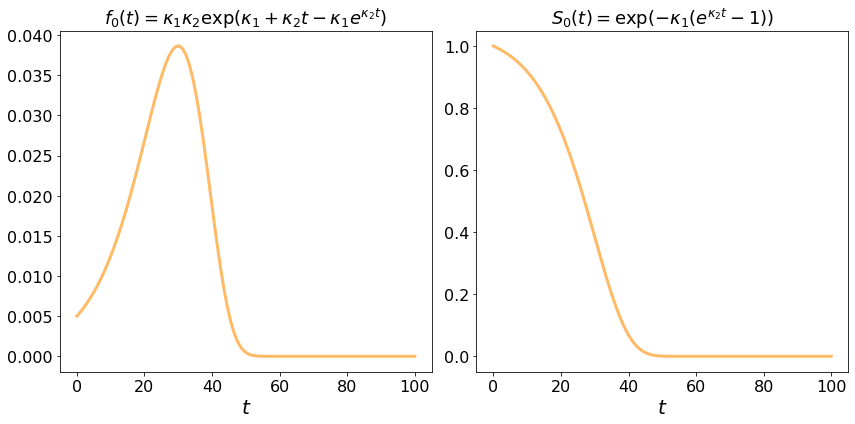

In [9]:
scale, shape = simu.scale, simu.shape
print("kappa_1=%s, kappa_2=%s" % (scale, shape))

fig = plt.figure(figsize=(12, 6))
# Density function plot
ax = fig.add_subplot(121)
t = np.linspace(0, 100, 100)
ax.plot(t, gompertz_pdf(t, shape, scale), '-', color='darkorange', lw=3, alpha=0.6)
plt.xlabel(r"$t$", fontsize=fontsize+4)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.title(r"$f_0(t) = \kappa_1 \kappa_2 \exp (\kappa_1 + \kappa_2 t -\kappa_1 e^{\kappa_2 t})$", 
          size=fontsize+2)

# Survival function plot
ax = fig.add_subplot(122)
t = np.linspace(0, 100, 100)
ax.plot(t, gompertz_survival(t, shape, scale), '-', color='darkorange', lw=3, alpha=0.6)
plt.xlabel(r"$t$", fontsize=fontsize+4)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.title(r"$S_0(t) = \exp (-\kappa_1 (e^{\kappa_2 t} - 1) )$", size=fontsize+2)

fig.tight_layout()
plt.show()

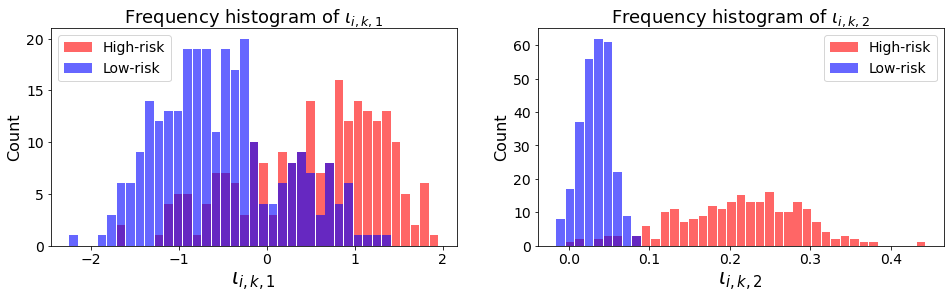

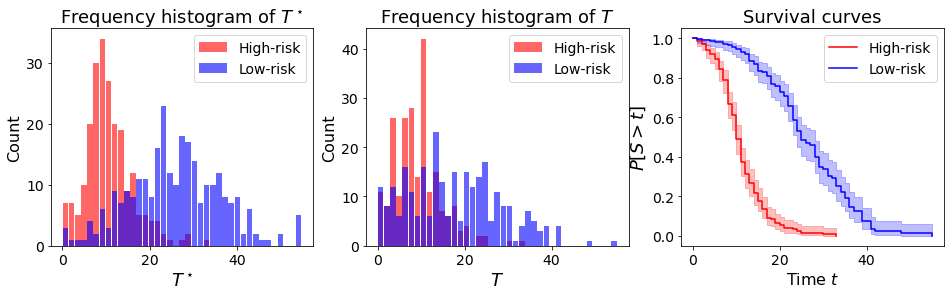

In [10]:
fig = plt.figure(figsize=(16, 4))
iotas = simu.iotas
for i in [1, 2]:
    ax = fig.add_subplot(1,2,i)
    iota_0i, iota_1i = iotas[i]
    all_iota = list(iota_0i) + list(iota_1i)
    mini, maxi = min(all_iota), max(all_iota)
    bins = np.linspace(mini, maxi, 40)
    kwargs = dict(bins=bins, alpha=0.6, rwidth=0.9)
    plt.hist(iota_1i, **kwargs, color='r', label='High-risk')
    plt.hist(iota_0i, **kwargs, color='b', label='Low-risk')
    plt.xlabel(r"$\iota_{i,k,%s}$" % i, size=fontsize + 5)
    plt.ylabel("Count", size=fontsize)
    plt.legend(fontsize=fontsize-2)
    ax.tick_params(labelsize=fontsize-2)
    plt.title("Frequency histogram of " + r'$\iota_{i,k,%s}$' % i, size=fontsize+2)
plt.show()

fig = plt.figure(figsize=(16, 4))
G = simu.latent_class
T_star = simu.event_times
times, labels = [T_star, T], ['T^\star', 'T']
for i in [0, 1]:
    ax = fig.add_subplot(1,3,i+1)
    df = pd.DataFrame(data={"time": times[i], "group": G})
    bins = np.linspace(0, times[i].max(), 40)
    kwargs = dict(bins=bins, alpha=0.6, rwidth=0.9)
    plt.hist(df.loc[df.group == 1, 'time'], **kwargs, color='r', label='High-risk')
    plt.hist(df.loc[df.group==0, 'time'], **kwargs, color='b', label='Low-risk')
    plt.legend(fontsize=fontsize-2)
    plt.xlabel(r'$%s$' % labels[i], size=fontsize+2)
    plt.ylabel("Count", size=fontsize)
    ax.tick_params(labelsize=fontsize-2)
    plt.title("Frequency histogram of " + r'$%s$' % labels[i], size=fontsize+2)

# Kaplan Meier estimation of survival curves
kmf = KaplanMeierFitter()
ax = plt.subplot(133)
kmf.fit(T[G == 1], delta[G == 1], label="High-risk").plot(ax=ax, c='r')
kmf.fit(T[G == 0], delta[G == 0], label="Low-risk").plot(ax=ax, c='b')
plt.legend(fontsize=fontsize-2)
plt.xlabel('Time $t$', size=fontsize)
plt.ylabel(r'$P[S > t]$', size=fontsize+2)
plt.title("Survival curves", size=fontsize+2)
ax.tick_params(labelsize=fontsize-2)
plt.show()

### Visualize longitudinal processes for two subjects randomly chosen

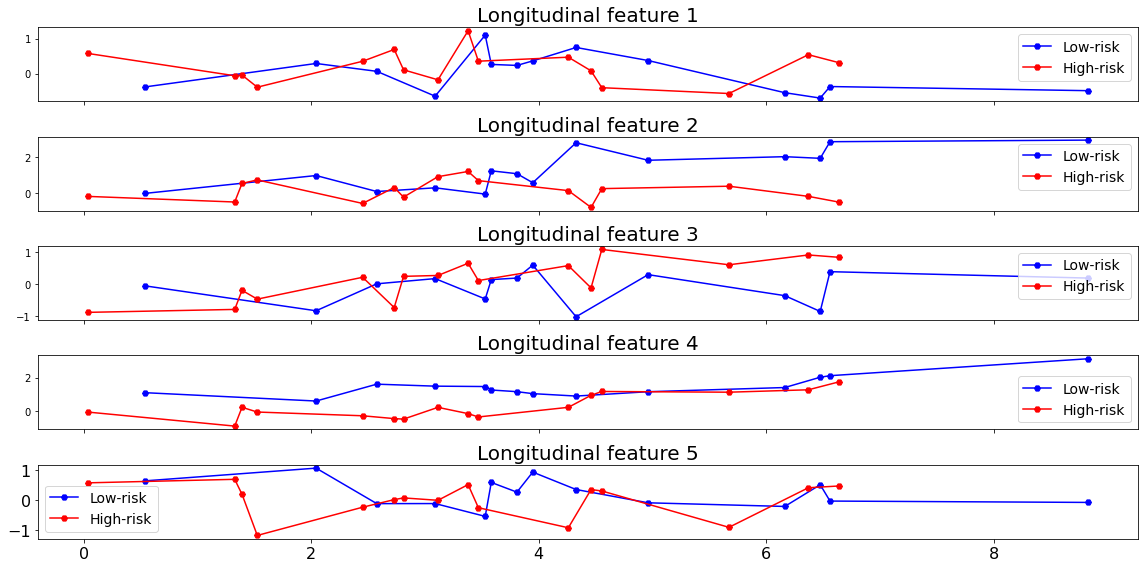

In [11]:
np.random.seed(10)
fig, ax = plt.subplots(simu.n_long_features, 1, sharex=True, figsize=(16,8))
colors, labels = ['b', 'r'], ['Low-risk', 'High-risk']
idxs = [0, 9]
for k in [0, 1]:
    Y_i = Y[Y.id == idxs[k]]
    label, color = labels[k], colors[k]
    for l in range(1, simu.n_long_features + 1):
        Y_il = Y_i[["T_long", "time_dep_feat%s" % l]]
        ax[l-1].plot(Y_il["T_long"], Y_il["time_dep_feat%s" % l], label=label, color=color, marker='H',)
        ax[l-1].set_title("Longitudinal feature %s" % l, fontsize=fontsize+4)
        plt.xticks(fontsize=fontsize), plt.yticks(fontsize=fontsize)
        ax[l-1].legend(fontsize=fontsize-2)
fig.tight_layout()
plt.show()

In [ ]:
# Kaplan Meier estimation of survival curves
kmf = KaplanMeierFitter()
ax = plt.subplot(133)
kmf.fit(T[G == 1], delta[G == 1], label="High-risk").plot(ax=ax, c='r')
kmf.fit(T[G == 0], delta[G == 0], label="Low-risk").plot(ax=ax, c='b')
plt.legend(fontsize=fontsize-2)
plt.xlabel('Time $t$', size=fontsize)
plt.ylabel(r'$P[S > t]$', size=fontsize+2)
plt.title("Survival curves", size=fontsize+2)
ax.tick_params(labelsize=fontsize-2)
plt.show()

# Lights learning

## Initializer illustration

Since our QNMCEM algorithm gives a local minimum, it is clever to choose an initial value $\theta^{(0)}$ close to the final solution $\hat \theta$, so that the number of iterations required to reach convergence is reduced.

The longitudinal submodels parameters $\beta_k^{(0)}$, $D^{(0)}$ and $\phi^{(0)}$ are initialized (like if there is no subgroup ($\beta_0^{(0)} = \beta_{1}^{(0)}$)) using a multivariate linear mixed model (MLMM) with an explicit EM algorithm, being itself initialized with univariates fits (ULMM). Let us test those initializer on a simple example.

### Simulation with no latent subgroups

In [12]:
from lights.init.mlmm import MLMM
from lights.base.base import extract_features
from lights.base.utils import plot_history

# high_risk_rate=0 for no subgroups
simu_ = SimuJointLongitudinalSurvival(seed=1, n_samples=200, n_time_indep_features=5,
                                      n_long_features=3, high_risk_rate=0, sparsity=1)
Y_ = simu_.simulate()[1]
# Get true beta parameter
true_beta_ = simu_.fixed_effect_coeffs[0]

-----------------------------------------------------------
Launching simulation using SimuJointLongitudinalSurvival...
Done simulating using SimuJointLongitudinalSurvival in 3.93e-02 seconds.


### Initialization with MLMM

Launching the solver MLMM...
 n_iter  |   obj    | rel_obj 
       0 |  7819.23 |      inf
      10 |   5257.4 | 6.26e-04
      20 |  5238.53 | 2.43e-04
      30 |  5229.16 | 1.41e-04
      40 |  5223.14 | 9.97e-05
      50 |  5218.48 | 8.30e-05
      60 |  5214.36 | 7.64e-05
      70 |  5210.46 | 7.39e-05
      80 |  5206.64 | 7.30e-05
      90 |  5202.85 | 7.27e-05
     100 |  5199.08 | 7.26e-05
     110 |   5195.3 | 7.25e-05
     120 |  5191.54 | 7.24e-05
     130 |  5187.79 | 7.20e-05
     140 |  5184.08 | 7.14e-05
     150 |   5180.4 | 7.06e-05
     160 |  5176.78 | 6.94e-05
     170 |  5173.22 | 6.80e-05
     180 |  5169.76 | 6.62e-05
     190 |  5166.39 | 6.41e-05
     200 |  5163.15 | 6.17e-05
     210 |  5160.03 | 5.90e-05
     220 |  5157.07 | 5.61e-05
     230 |  5154.27 | 5.28e-05
     240 |  5151.64 | 4.94e-05
     250 |   5149.2 | 4.59e-05
     260 |  5146.93 | 4.23e-05
     270 |  5144.86 | 3.87e-05
     280 |  5142.97 | 3.51e-05
     290 |  5141.26 | 3.17e-05
     300 |

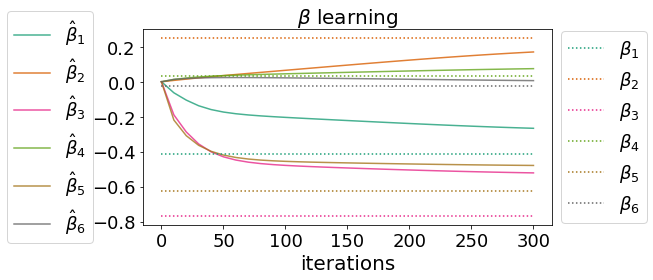

In [13]:
fixed_effect_time_order = 1
tol = 1e-5
mlmm = MLMM(print_every=10, fixed_effect_time_order=fixed_effect_time_order, 
            tol=tol, initialize=False, max_iter=300)
# Get design features matrices
extracted_features = extract_features(Y_, simu_.time_dep_feat, fixed_effect_time_order)
# Train the initializer
mlmm.fit(extracted_features)

# Visualize learning
to = len(true_beta_)+1
leg1 = [r"$\hat \beta_%s$" % j for j in range(1, to)]
leg2 = [r"$\beta_%s$" % j for j in range(1, to)]
visualize_vect_learning(mlmm, "fixed_effect_coeffs", r"$\beta$", true_beta_, leg1, leg2)

## Data splitting

In [14]:
# Split data into training and test sets 
test_size = .3  # proportion of data used for testing
rs = ShuffleSplit(n_splits=1, test_size=test_size, random_state=0)

data_index = np.unique(Y.id.values)
for train_index, test_index in rs.split(X):
    train_index = np.sort(train_index)
    test_index = np.sort(test_index)
    data_index_train = data_index[train_index]
    data_index_test = data_index[test_index]
    X_test = X[test_index]
    Y_test = Y[Y.id.isin(data_index_test)]
    T_test = T[test_index]
    delta_test = delta[test_index]
    
    X_train = X[train_index]
    Y_train = Y[Y.id.isin(data_index_train)]
    T_train = T[train_index]
    delta_train = delta[train_index]

print("%d%% for training, %d%% for testing." 
      % ((1 - test_size) * 100, test_size * 100))

70% for training, 30% for testing.


## Feature-screening

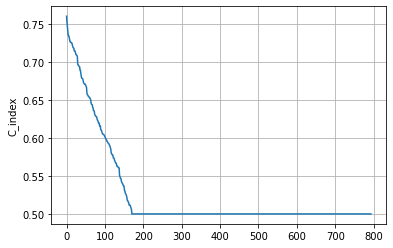

In [15]:
from tsfresh import extract_features as extract_rep_features
from sksurv.linear_model import CoxPHSurvivalAnalysis
from tsfresh.feature_extraction import ComprehensiveFCParameters

fc_parameters = ComprehensiveFCParameters()
ext_feat = extract_rep_features(Y_train, column_id="id",
                                    column_sort="T_long",
                                    default_fc_parameters=fc_parameters,
                                    impute_function=None,
                                    disable_progressbar=True
                                    )
y = np.zeros(len(T_train), dtype={'names':('indicator', 'time'), 'formats':('?', 'f8')})
y['indicator'] = delta_train
y['time'] = T_train
    
scores = {}
idx = 0
asso_feat_names = ext_feat.columns
n_asso_feat = len(asso_feat_names) // simu.n_long_features
for key, val in fc_parameters.items():
    if val is not None:
        tmp = fc_parameters[key]
        score_tmp = []
        for val in tmp:
            feat = {key : [val]}
            asso_feat = ext_feat[asso_feat_names[idx:-1:n_asso_feat]]
            try:
                model = CoxPHSurvivalAnalysis().fit(asso_feat, y)
            except:
                score_tmp.append(0.5)
            else:
                score_tmp_ = model.score(asso_feat, y)
                score_tmp.append(max(score_tmp_, 1 - score_tmp_))
            idx += 1
        scores[key] = score_tmp
    else:
        feat = {key : val}
        asso_feat = ext_feat[asso_feat_names[idx:-1:n_asso_feat]]
        try:
            model = CoxPHSurvivalAnalysis().fit(asso_feat, y)
        except:
            scores[key] = 0.5
        else:
            score_tmp_ = model.score(asso_feat, y)
            scores[key] = max(score_tmp_, 1 - score_tmp_)
        idx += 1
        
flat_score = []
for item in list(scores.values()):
    if isinstance(item, list):
        flat_score += item
    else:
        flat_score += [item]

sorted_score = -np.sort(-np.array(flat_score))
plt.plot(sorted_score)
plt.ylabel("C_index")
plt.grid()
plt.show()

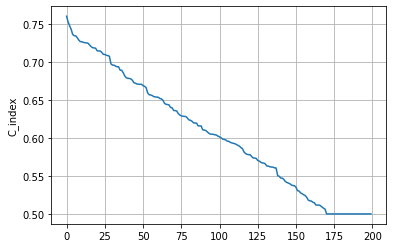

In [16]:
plt.plot(sorted_score[:200])
plt.ylabel("C_index")
plt.grid()
plt.show()

In [17]:
score_threshold = sorted_score[50]
selected_fc_parameters = {}
scores_ = {}
for key, val in fc_parameters.items():
    score = scores[key]
    if val is not None:
        tmp = []
        score_tmp = []
        for idx in range(len(score)):
            if score[idx] >= score_threshold:
                tmp.append(val[idx])
                score_tmp.append(score[idx])
        if tmp:
            selected_fc_parameters[key] = tmp
            scores_[key] = score_tmp
            
    else:
        if score >= score_threshold:
            selected_fc_parameters[key] = val
            scores_[key] = score

## Remove correlation

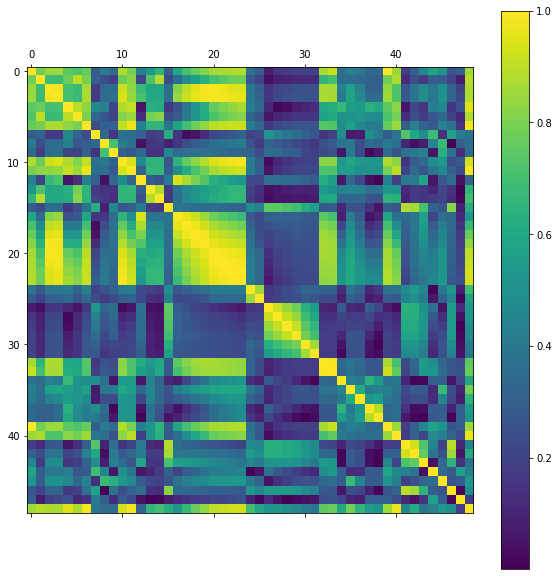

In [18]:
ext_feat = extract_rep_features(Y_train, column_id="id",
                                column_sort="T_long",
                                default_fc_parameters=selected_fc_parameters,
                                impute_function=None,
                                disable_progressbar=True
                                )
nb_extracted_feat = len(ext_feat.columns) // simu.n_long_features
n_train_sample = ext_feat.shape[0]
ext_feat_df = ext_feat.values.reshape(n_train_sample, simu.n_long_features, nb_extracted_feat)
ext_feat_df = ext_feat_df.T.reshape(nb_extracted_feat, -1).T
cor_matrix =  pd.DataFrame(ext_feat_df).corr().abs()
plt.figure(figsize=(10, 10))
plt.matshow(cor_matrix, fignum=1)
cb = plt.colorbar()
plt.show()

In [19]:
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))
drop_columns = [column for column in upper_tri.columns if any(upper_tri[column] > 0.8)]

col_idx = 0
final_fc_parameters = {}
final_scores = {}
for key, val in selected_fc_parameters.items():
    score = scores_[key]
    if val is not None:
        tmp = []
        score_tmp = []
        for idx in range(len(val)):
            if col_idx not in drop_columns:
                tmp.append(val[idx])
                score_tmp.append(score[idx])
            col_idx += 1
        if tmp:
            final_fc_parameters[key] = tmp
            final_scores[key] = score_tmp
    else:
        if col_idx not in drop_columns:
            final_fc_parameters[key] = val
            final_scores[key] = score
        col_idx += 1

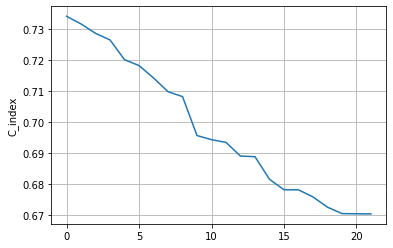

In [20]:
flat_score = []
for item in list(final_scores.values()):
    if isinstance(item, list):
        flat_score += item
    else:
        flat_score += [item]

sorted_score = -np.sort(-np.array(flat_score))
plt.plot(sorted_score)
plt.ylabel("C_index")
plt.grid()
plt.show()

In [21]:
score_threshold = sorted_score[9]
final_selected_fc_parameters = {}
scores_ = {}
for key, val in final_fc_parameters.items():
    score = final_scores[key]
    if val is not None:
        tmp = []
        score_tmp = []
        for idx in range(len(score)):
            if score[idx] >= score_threshold:
                tmp.append(val[idx])
                score_tmp.append(score[idx])
        if tmp:
            final_selected_fc_parameters[key] = tmp
            scores_[key] = score_tmp
            
    else:
        if score >= score_threshold:
            final_selected_fc_parameters[key] = val
            scores_[key] = score

In [22]:
final_selected_fc_parameters

{'sum_values': None,
 'abs_energy': None,
 'standard_deviation': None,
 'time_reversal_asymmetry_statistic': [{'lag': 1}],
 'cid_ce': [{'normalize': True}],
 'agg_autocorrelation': [{'f_agg': 'mean', 'maxlag': 40}],
 'change_quantiles': [{'ql': 0.0, 'qh': 1.0, 'isabs': False, 'f_agg': 'mean'}],
 'range_count': [{'min': -1000000000000.0, 'max': 0},
  {'min': 0, 'max': 1000000000000.0}],
 'mean_n_absolute_max': [{'number_of_maxima': 7}]}

## Training 

Launching the solver prox_QNEM...
Launching the solver MLMM...
Launching the solver ULMM...
Done solving using ULMM in 5.02e+00 seconds
 n_iter  |   obj    | rel_obj 
       0 |  16248.3 |      inf
       1 |  15484.5 | 4.70e-02
       2 |  15261.4 | 1.44e-02
       3 |  15157.6 | 6.80e-03
       4 |  15096.7 | 4.02e-03
       5 |  15056.7 | 2.65e-03
       6 |  15028.6 | 1.86e-03
       7 |    15008 | 1.37e-03
       8 |  14992.4 | 1.04e-03
       9 |  14980.3 | 8.08e-04
      10 |  14970.7 | 6.43e-04
      11 |  14962.9 | 5.21e-04
      12 |  14956.5 | 4.28e-04
      13 |  14951.2 | 3.56e-04
      14 |  14946.7 | 3.00e-04
      15 |  14942.9 | 2.56e-04
      16 |  14939.6 | 2.20e-04
      17 |  14936.7 | 1.90e-04
      18 |  14934.2 | 1.66e-04
      19 |  14932.1 | 1.46e-04
      20 |  14930.1 | 1.29e-04
Done solving using MLMM in 1.62e+01 seconds
 n_iter  |   obj    | rel_obj 
       0 |  61.8714 |      inf
       1 |  47.1785 | 2.37e-01
       2 |  45.7592 | 3.01e-02
       3 |   4

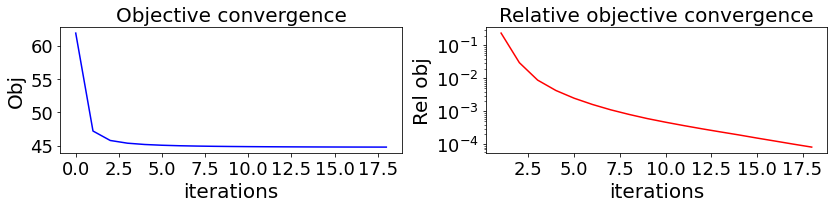

In [23]:
from lights.inference import prox_QNEM

## Choose parameters ##
tol = 1e-6            # tolerance for the convergence stopping criterion 
eta = 0.3             # parameter controlling the trade-off between l1 
                      # and l2 regularization in the elasticNet
gamma_chosen = '1se'  # way to select l_elasticNet_chosen: '1se' or 'min'
warm_start = True     # at each L-BGFS-B iteration, reset beta to 0 or take 
                      # the previous value 
grid_size = 30        # grid size for the cross validation procedure
metric = 'C-index'    # cross-validation metric: 'log_lik' or 'C-index'

#l_pen_EN, l_pen_SGL = best_param.values()
# Training with hyper-params set manually
l_pen_EN, l_pen_SGL = .04, .75
eta_sp_gp_l1 = .9
fixed_effect_time_order = 1
eta_elastic_net = .1
learner = prox_QNEM(fixed_effect_time_order=fixed_effect_time_order, max_iter=20, print_every=1,
               l_pen_SGL=l_pen_SGL, l_pen_EN=l_pen_EN, eta_sp_gp_l1 = eta_sp_gp_l1, initialize=True, 
                fc_parameters=final_selected_fc_parameters, eta_elastic_net=eta_elastic_net)
learner.fit(X_train, Y_train, T_train, delta_train)

# Visualize learning
visualize_vect_learning(learner, "obj")

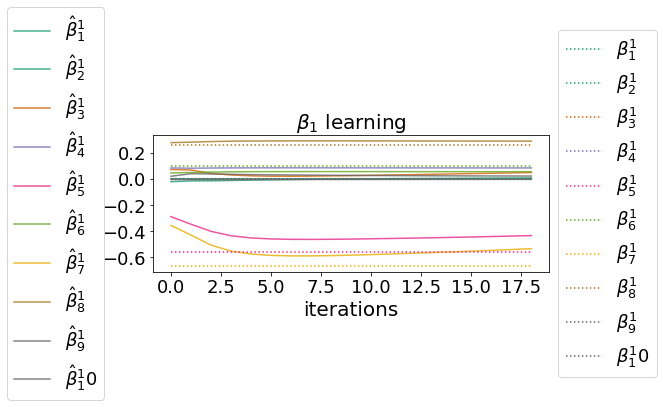

In [25]:
# Visualize beta_1
true_beta_1 = simu.fixed_effect_coeffs[0].reshape(-1, 1)
to = len(true_beta_1)+1
leg1 = [r"$\hat \beta^1_%s$" % j for j in range(1, to)]
leg2 = [r"$\beta^1_%s$" % j for j in range(1, to)]
visualize_vect_learning(learner, "beta_0", r"$\beta_1$", true_beta_1, leg1, leg2)

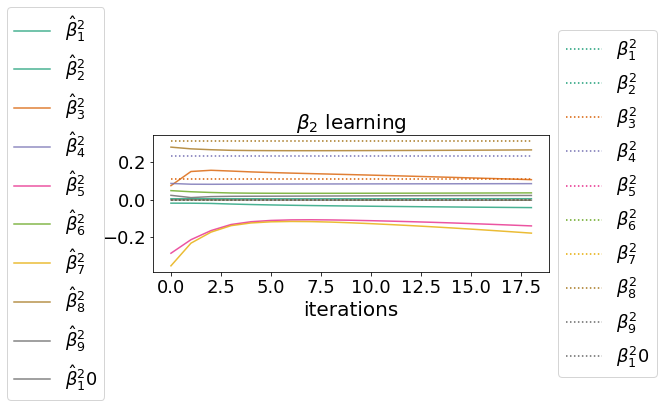

In [24]:
# Visualize beta_2
true_beta_2 = simu.fixed_effect_coeffs[1].reshape(-1, 1)
to = len(true_beta_2)+1
leg1 = [r"$\hat \beta^2_%s$" % j for j in range(1, to)]
leg2 = [r"$\beta^2_%s$" % j for j in range(1, to)]
visualize_vect_learning(learner, "beta_1", r"$\beta_2$", true_beta_2, leg1, leg2)

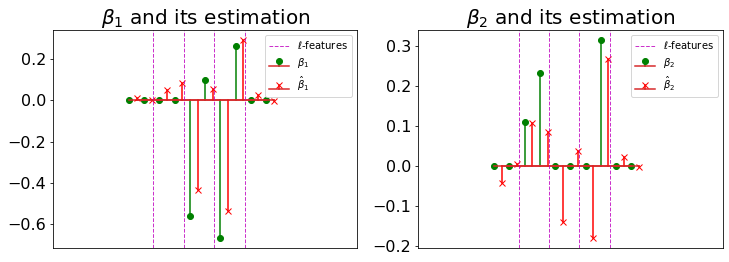

In [27]:
beta_1_true = true_beta_1
beta_1_est = learner.theta["beta_0"]
fig = plt.figure(figsize=(12, 4))
fontsize = 16
ax = fig.add_subplot(121)
ax.stem(np.arange(len(beta_1_true)).tolist(), beta_1_true, linefmt='g-', markerfmt='go', label= r"$\beta_1$")
ax.stem((np.arange(len(beta_1_est)) + .5).tolist(), beta_1_est, linefmt='r-', markerfmt='rx', label= r"$\hat \beta_1$")
ax.set_xlim([-5, len(beta_1_true) + 5])
ax.set_title(r"$\beta_1$ and its estimation", fontsize=fontsize+4)
plt.legend(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.tick_params(axis='x', bottom=False, labelbottom=False)
visualize_vect_per_group(beta_1_true, simu.n_long_features, ax)

beta_2_true = true_beta_2
beta_2_est = learner.theta["beta_1"]
fontsize = 16
ax = fig.add_subplot(122)
ax.stem(np.arange(len(beta_2_true)).tolist(), beta_2_true, linefmt='g-', markerfmt='go', label= r"$\beta_2$")
ax.stem((np.arange(len(beta_2_est)) + .5).tolist(), beta_2_est, linefmt='r-', markerfmt='rx', label= r"$\hat \beta_2$")
ax.set_xlim([-5, len(beta_1_true) + 5])
ax.set_title(r"$\beta_2$ and its estimation", fontsize=fontsize+4)
plt.legend(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.tick_params(axis='x', bottom=False, labelbottom=False)
visualize_vect_per_group(beta_1_true, simu.n_long_features, ax)
plt.show()

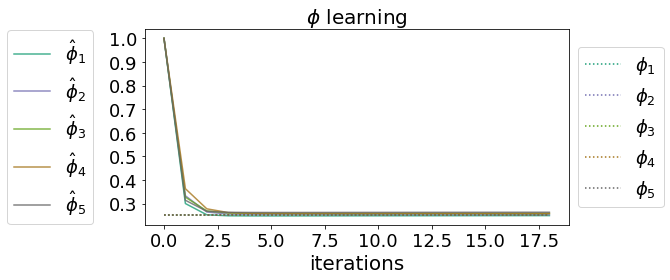

In [28]:
# Visualize phi
true_phi = np.array([simu.std_error ** 2] * simu.n_long_features).reshape(-1, 1)
to = len(true_phi)+1
leg1 = [r"$\hat \phi_%s$" % j for j in range(1, to)]
leg2 = [r"$\phi_%s$" % j for j in range(1, to)]
visualize_vect_learning(learner, "phi", symbol = r"$\phi$", true_coeffs = true_phi, legend_est = leg1, legend_true = leg2)

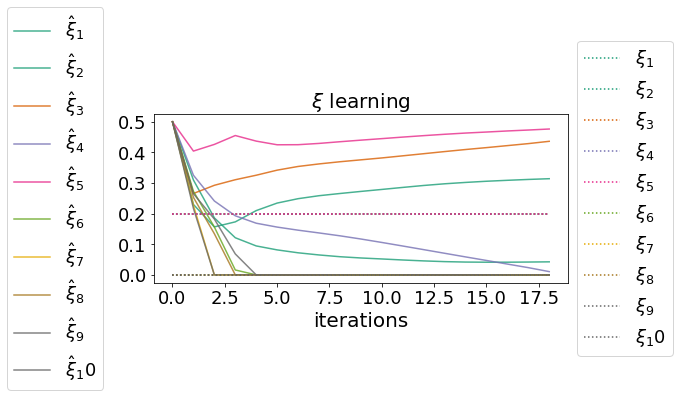

In [29]:
# Visualize xi
true_xi = simu.time_indep_coeffs.reshape(-1, 1)
to = len(true_xi)+1
leg1 = [r"$\hat \xi_%s$" % j for j in range(1, to)]
leg2 = [r"$\xi_%s$" % j for j in range(1, to)]
visualize_vect_learning(learner, "xi", r"$\xi$", true_xi, leg1, leg2)

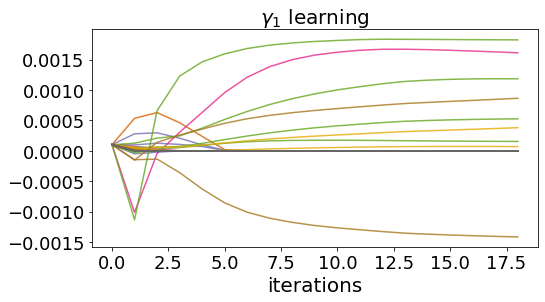

In [31]:
# Visualize gamma_0
to = len(learner.theta["gamma_0"])+1
leg1 = [r"$\hat \gamma^1_{%s}$" % j for j in range(1, to)]
leg2 = [r"$\gamma^1_{%s}$" % j for j in range(1, to)]
visualize_vect_learning(learner, "gamma_0", r"$\gamma_1$", leg1, leg2)

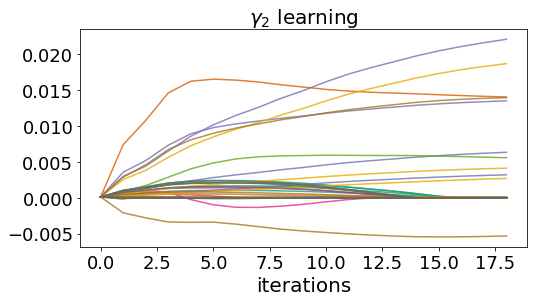

In [32]:
# Visualize gamma_1
to = len(learner.theta["gamma_1"])+1
leg1 = [r"$\hat \gamma^2_{%s}$" % j for j in range(1, to)]
leg2 = [r"$\gamma^2_{%s}$" % j for j in range(1, to)]
visualize_vect_learning(learner, "gamma_1", r"$\gamma_2$", leg1, leg2)

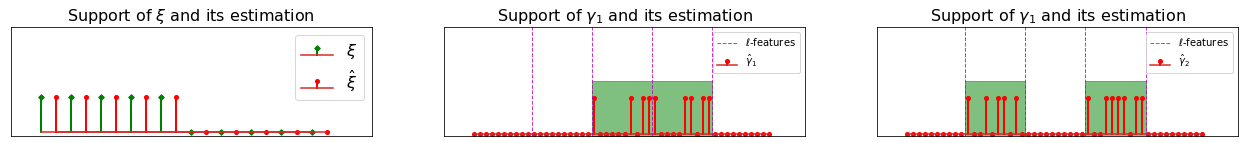

In [58]:
fig = plt.figure(figsize=(22, 2))
fontsize = 16

xi_true = true_xi
xi_est = learner.theta["xi"]
xi_est_support = (xi_est != 0).astype(int)
xi_true_support = (xi_true != 0).astype(int)
ax = fig.add_subplot(131)
markerline, stemline, baseline, = ax.stem(np.arange(len(xi_true)).tolist(), xi_true_support,
                                          linefmt='g-', markerfmt='gD', label= r"$\xi$")
plt.setp(stemline, linewidth = 2)
plt.setp(markerline, markersize = 4)
markerline, stemline, baseline, = ax.stem((np.arange(len(xi_est)) + .5).tolist(), xi_est_support,
                                          linefmt='r-', markerfmt='ro', label= r"$\hat \xi$")
plt.setp(stemline, linewidth = 2)
plt.setp(markerline, markersize = 4)
ax.set_xlim([-1, len(true_xi) + 1])
ax.set_title(r"Support of $\xi$ and its estimation", fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.yticks([])
plt.ylim(-0.1, 3)
plt.tick_params(axis='x', bottom=False, labelbottom=False)

L = Y.shape[1] - 2
S_k = simu.S_k
nb_asso_param = learner.theta["gamma_0"].flatten().shape[0] // L
nb_extracted_feat_param = learner.nb_extracted_feat
nb_noise_param = nb_asso_param - nb_extracted_feat_param
gamma_1_true_support = []
for l in range(L):
    if l in S_k[0]:
        gamma_1_true_support += [0] * nb_asso_param 
    else:
        gamma_1_true_support += [1] *  nb_extracted_feat_param + [0] * nb_noise_param
gamma_1_est_support = (learner.theta["gamma_0"].copy() != 0).astype(int)
gamma_1_true_support = np.array(gamma_1_true_support)
ax = fig.add_subplot(132)
markerline, stemline, baseline, = ax.stem((np.arange(len(gamma_1_est_support))).tolist(), gamma_1_est_support,
                                          linefmt='r-', markerfmt='ro', label= r"$\hat \gamma_1$")
plt.setp(stemline, linewidth = 2)
plt.setp(markerline, markersize = 4)
ax.set_xlim([-5, len(gamma_1_true_support) + 5])
ax.set_title(r"Support of $\gamma_1$ and its estimation", fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.yticks([])
plt.ylim(-0.05, 3)
plt.tick_params(axis='x', bottom=False, labelbottom=False)
visualize_vect_per_group(gamma_1_true_support, simu.n_long_features, ax, plot_area=True)

gamma_2_true_support = []
for l in range(L):
    if l in S_k[1]:
        gamma_2_true_support += [0] * nb_asso_param
    else:
        gamma_2_true_support += [1] *  nb_extracted_feat_param + [0] * nb_noise_param
gamma_2_est_support = (learner.theta["gamma_1"].copy() != 0).astype(int)
gamma_2_true_support = np.array(gamma_2_true_support)
ax = fig.add_subplot(133)
markerline, stemline, baseline, = ax.stem((np.arange(len(gamma_2_est_support))).tolist(), gamma_2_est_support,
                                          linefmt='r-', markerfmt='ro', label= r"$\hat \gamma_2$")
plt.setp(stemline, linewidth = 2)
plt.setp(markerline, markersize = 4)
ax.set_xlim([-5, len(gamma_2_true_support) + 5])
ax.set_title(r"Support of $\gamma_1$ and its estimation", fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.yticks([])
plt.ylim(-0.05, 3)
plt.tick_params(axis='x', bottom=False, labelbottom=False)
visualize_vect_per_group(gamma_2_true_support, simu.n_long_features, ax, plot_area=True)
plt.show()

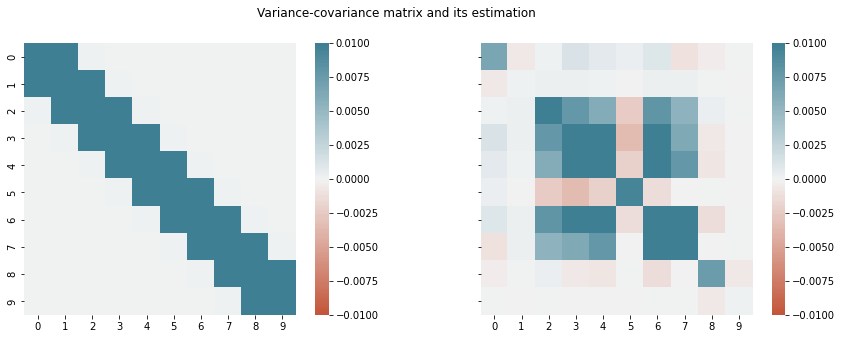

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
fig.suptitle('Variance-covariance matrix and its estimation')

sns.heatmap(
    data=simu.long_cov, 
    vmin=-.01, vmax=.01, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True, ax=axes[0]
)

sns.heatmap(
    data=learner.theta["long_cov"], 
    vmin=-.01, vmax=.01, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True, ax=axes[1]
)

<function matplotlib.pyplot.show(*args, **kw)>

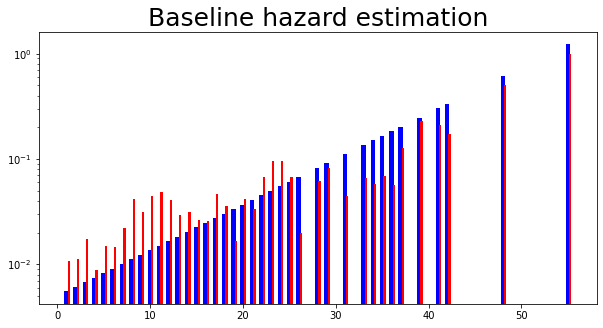

In [29]:
times = learner.theta["baseline_hazard"].index.values
est_value = learner.theta["baseline_hazard"].values
true_value = (simu.scale * simu.shape) * np.exp(simu.shape * times)
non_zero_idx = np.argwhere(est_value != 0)
fig = plt.figure(figsize=(10, 5))
plt.bar(times, true_value, color = 'b', width = 0.5)
plt.bar(times + 0.25, est_value, color = 'r', width = 0.25)
plt.title("Baseline hazard estimation", fontsize=25)
plt.yscale('log')
plt.show

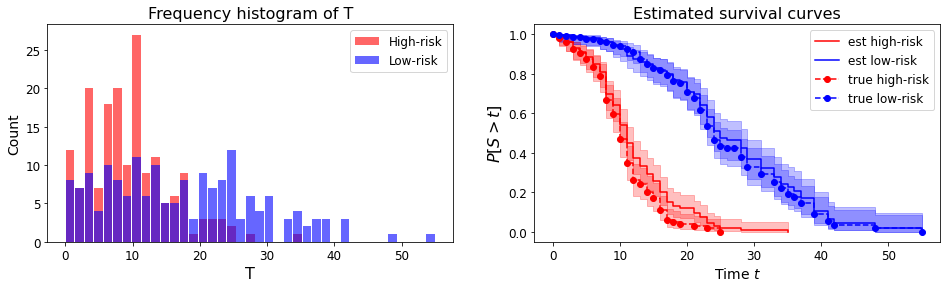

In [30]:
G_train = simu.latent_class[train_index]
# estimation of G
est_G = (learner.pi_est > .5).astype(int)
fig = plt.figure(figsize=(16, 4))
fontsize = 14
ax = fig.add_subplot(1,2,1)
bins = np.linspace(0, T_train.max(), 40)
kwargs = dict(bins=bins, alpha=0.6, rwidth=0.9)
plt.hist(T_train[est_G == 1], **kwargs, color='r', label='High-risk')
plt.hist(T_train[est_G == 0], **kwargs, color='b', label='Low-risk')
plt.legend(fontsize=fontsize-2)
plt.xlabel("T", size=fontsize+2)
plt.ylabel("Count", size=fontsize)
ax.tick_params(labelsize=fontsize-2)
plt.title("Frequency histogram of T", size=fontsize+2)

# Kaplan Meier estimation of survival curves
kmf = KaplanMeierFitter()
ax = plt.subplot(122)
kmf.fit(T_train[est_G == 1], delta_train[learner.pi_est > .5], label="est high-risk").plot(ax=ax, c='r')
kmf.fit(T_train[est_G == 0], delta_train[learner.pi_est < .5], label="est low-risk").plot(ax=ax, c='b')
kmf.fit(T_train[G_train == 1], delta_train[G_train == 1], label="true high-risk").plot(ax=ax, c='r', marker='o', linestyle='dashed')
kmf.fit(T_train[G_train == 0], delta_train[G_train == 0], label="true low-risk").plot(ax=ax, c='b', marker='o', linestyle='dashed')
plt.legend(fontsize=fontsize-2)
plt.xlabel('Time $t$', size=fontsize)
plt.ylabel(r'$P[S > t]$', size=fontsize+2)
plt.title("Estimated survival curves", size=fontsize+2)
ax.tick_params(labelsize=fontsize-2)
plt.show()

## Visualize pi_est

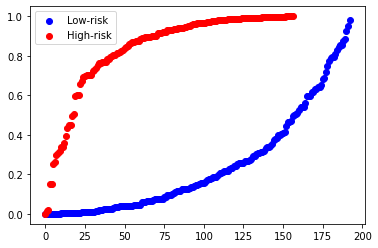

In [31]:
n1 = sum(G_train)
n0 = len(G_train) - n1
plt.scatter(np.arange(n0), np.sort(learner.pi_est[G_train == 0]), c='b', label="Low-risk")
plt.scatter(np.arange(n1), np.sort(learner.pi_est[G_train == 1]), c='r', label="High-risk")
plt.legend()
plt.show()

## Prediction

In [32]:
# evalutation here
c_index_train = learner.score(X_train, Y_train, T_train, delta_train)

## Obtain the marker vector on test set ##

# prediction here
c_index_test = learner.score(X_test, Y_test, T_test, delta_test)

print("Done predicting on dataset.")
print("C-index on train: %.2f" % c_index_train)
print("C-index on test: %.2f" % c_index_test)

Done predicting on dataset.
C-index on train: 0.77
C-index on test: 0.79
